<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/02-end-to-end-ml-project/v2_end_to_end_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##End-to-end Machine Learning project

In this notebook you will work through an example project end to end, pretending to
be a recently hired data scientist at a real estate company. 

This example is fictitious;
the goal is to illustrate the main steps of a machine learning project, not to learn
anything about the real estate business. 

Here are the main steps we will walk through:

1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

##Setup

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
from zlib import crc32
from scipy.stats import binom
from scipy.stats import randint, uniform, geom, expon, reciprocal

import numpy as np

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

##Dataset

In [2]:
def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv("datasets/housing/housing.csv")

housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
# get a quick description of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# what categories exist and how many districts belong to each category
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# shows a summary of the numerical attributes
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

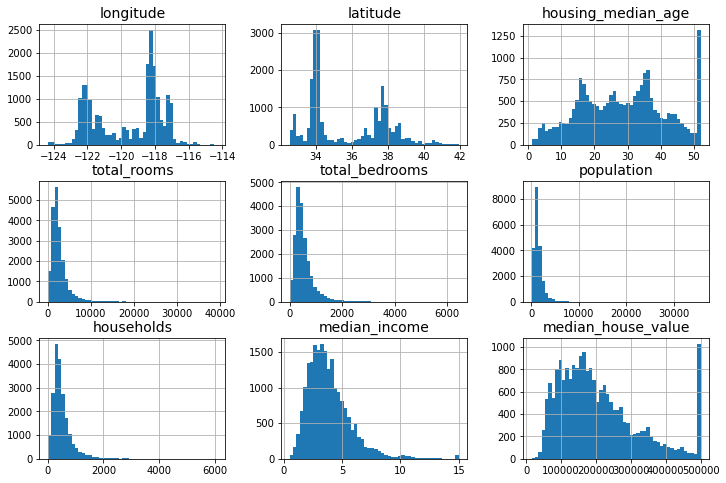

In [6]:
# plot histogram for each numerical attribute
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [7]:
# Creating a test set is theoretically simple; pick some instances randomly
def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  train_indices = shuffled_indices[test_set_size:]
  test_indices = shuffled_indices[:test_set_size]
  return data.iloc[train_indices], data.iloc[train_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 16512)

In [9]:
# there’s a shorter way to get a single split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

##Explore and Visualize the Data

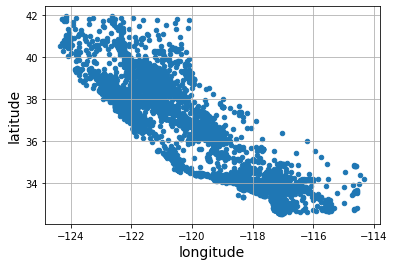

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

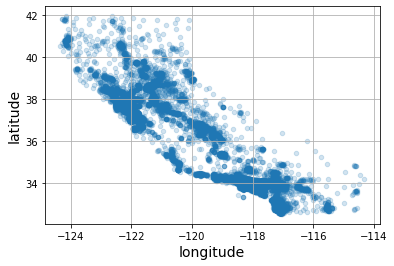

In [11]:
# makes it much easier to visualize the places where there is a high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

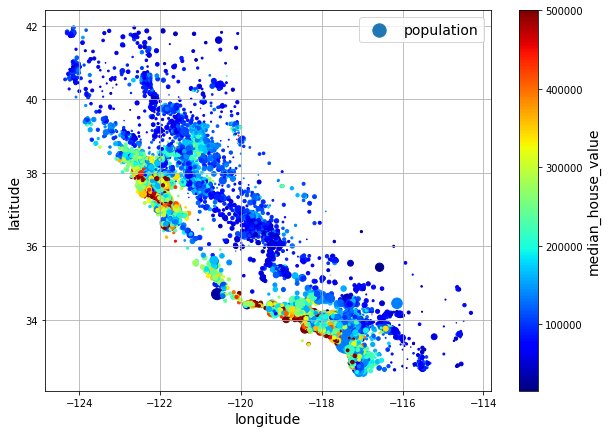

In [12]:
# look at the housing prices
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

###Correlations

In [13]:
# look at how much each attribute correlates with the median house value
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

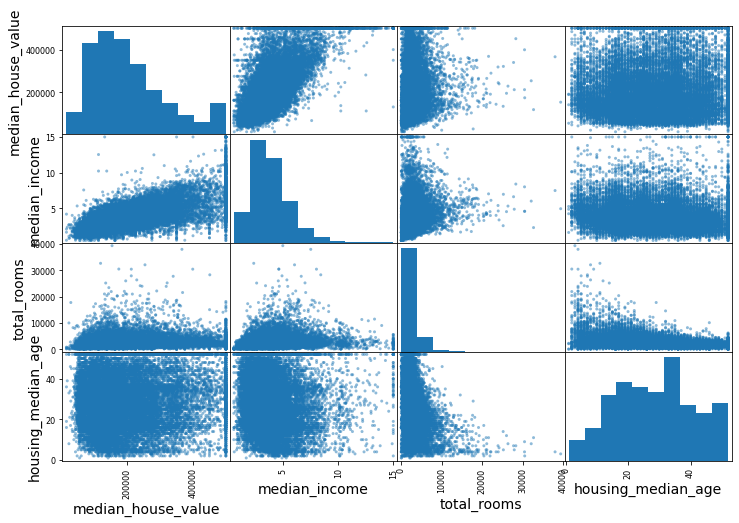

In [14]:
# let's see most correlated with the median housing value
attributes = [
  "median_house_value", "median_income", "total_rooms", "housing_median_age"
]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

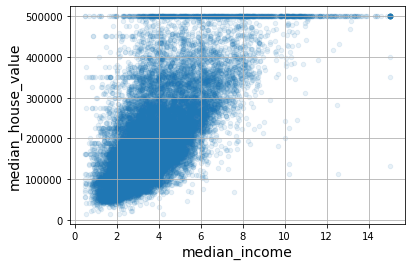

In [15]:
# let's zoom in on the most promising attribute
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.1)
plt.show()

###Attribute Combinations

In [16]:
# let's try out various attribute combinations
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [17]:
# And then you look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

##Data preparation

In [18]:
# let's separate the predictors and the labels
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

###Data Cleaning

In [19]:
# let's impute missing values
imputer = SimpleImputer(strategy="median")

housing_num_cols = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num_cols)

imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [20]:
# Check that this is the same as manually computing the median of each attribute
housing_num_cols.median().values

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [21]:
# Now transform the training set
X = imputer.transform(housing_num_cols)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

###Categorical Attributes

In [22]:
# let's preprocess the categorical input feature
housing_cat_cols = housing[["ocean_proximity"]]
housing_cat_cols.head(10)

ocean_proximity
14196      NEAR OCEAN
8267       NEAR OCEAN
17445        NEAR BAY
14265       <1H OCEAN
2271           INLAND
17848        NEAR BAY
6252           INLAND
9389        <1H OCEAN
6113           INLAND
6061        <1H OCEAN

In [23]:
housing_cat_cols.value_counts()

ocean_proximity
<1H OCEAN          7313
INLAND             5276
NEAR OCEAN         2091
NEAR BAY           1827
ISLAND                5
dtype: int64

In [24]:
# let’s convert these categories from text to numbers
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat_cols)
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [3.],
       [0.],
       [1.],
       [3.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [25]:
# get the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
# let's convert categorical values into one-hot vectors
one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat_cols)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
# let's convert it to a dense array
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [28]:
# Alternatively, you can set sparse=False when creating the OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat_cols)
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [29]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [30]:
# let's converts each categorical feature into a one-hot representation using Pandas
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                       1                         0
1                       0                         1

In [31]:
one_hot_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

###Feature Scaling

In [32]:
# let's do data normalization using Min-max scaling
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_cols_min_max_scaled = min_max_scaler.fit_transform(housing_num_cols)

In [33]:
# let's do data standardization using StandardScaler
std_scaler = StandardScaler()
housing_num_cols_std_scaled = std_scaler.fit_transform(housing_num_cols)

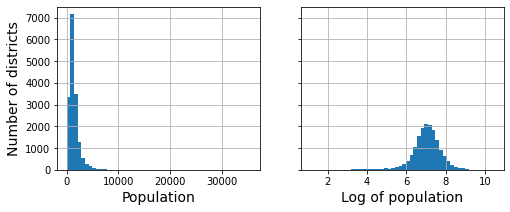

In [34]:
# Transforming a feature to make it closer to a Gaussian distribution
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

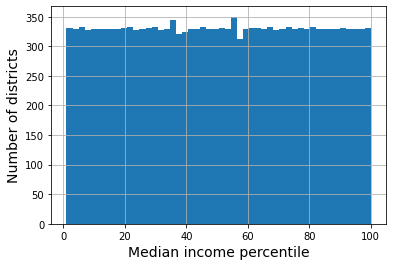

In [35]:
# What if we replace each value with its percentile?
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

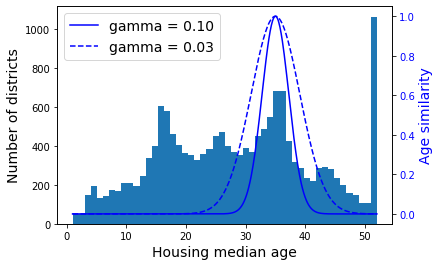

In [36]:
# let's create a new Gaussian RBF feature measuring the similarity between the housing median age and 35
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")

plt.show()

In [37]:
# let's train a simple linear regression model on the resulting scaled labels
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

# pretend this is new data
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[236054.10114638],
       [239237.69758773],
       [198830.83002753],
       [259972.41986486],
       [107097.77256737]])

In [38]:
# but a simpler option is to use a TransformedTargetRegressor
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)

# pretend this is new data
some_new_data = housing[["median_income"]].iloc[:5]

predictions = model.predict(some_new_data)
predictions

array([236054.10114638, 239237.69758773, 198830.83002753, 259972.41986486,
       107097.77256737])

###Custom Transformers

In [39]:
# Let’s create a log-transformer and apply it to the population feature
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing["population"])

In [40]:
# computes the same Gaussian RBF similarity measure
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.0]], gamma=0.1))
age_similar_35 = rbf_transformer.transform(housing[["housing_median_age"]]) 
age_similar_35

array([[9.04837418e-01],
       [7.18778174e-28],
       [7.44658307e-03],
       ...,
       [2.09879105e-16],
       [4.57533877e-08],
       [4.57533877e-08]])

In [41]:
# add a feature that will measure the geographic similarity
sf_coords = 37.7749, -122.41

sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_similar = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_similar

array([[0.00541506],
       [0.00416908],
       [0.99792036],
       ...,
       [0.30971195],
       [0.01673809],
       [0.0801399 ]])

In [42]:
# Custom transformers are also useful to combine features
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [43]:
# let's create custom transformer that acts much like the StandardScaler
class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, with_mean=True):
    self.with_mean = with_mean

  # y is required even though we don't use it
  def fit(self, X, y=None):
    X = check_array(X)  # checks that X is an array with finite float values
    self.mean_ = X.mean(axis=0)
    self.scale_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
    # always return self!
    return self

  def transform(self, X):
    check_is_fitted(self)  # looks for learned attributes (with trailing _)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.with_mean:
      X = X - self.mean_
    return X / self.scale_

In [44]:
# let's demonstrates custom transformer that uses a clusterer to identify the main clusters in the training data 
# and then measure how similar each sample is to each cluster center
class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters 
    self.gamma = gamma
    self.random_state = random_state 

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    # always return self!
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [45]:
# Now let’s use this custom transformer
cluster_similar = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_similar.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
similarities[:3].round(2)

array([[0.  , 0.05, 0.  , 0.  , 0.22, 0.93, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.  , 0.  , 0.15, 0.94, 0.  , 0.  , 0.  , 0.  ],
       [0.97, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.72, 0.1 , 0.21]])

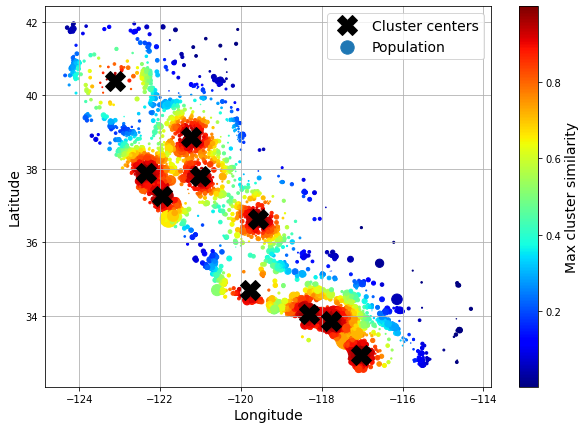

In [46]:
housing_renamed = housing.rename(columns={
  "latitude": "Latitude", "longitude": "Longitude",
  "population": "Population",
  "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_similar.kmeans_.cluster_centers_[:, 1],
         cluster_similar.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

###Transformation Pipelines

In [47]:
# let's create pipeline for numerical attributes, which will first impute then scale the input features
num_pipeline = Pipeline([
  ("impute", SimpleImputer(strategy="median")),
  ("standardize", StandardScaler())
])

In [48]:
# If you don’t want to name the transformers
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [49]:
# render the diagram
set_config(display='diagram')
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [50]:
# Let’s call the pipeline and look at the output’s first two rows
housing_num_prepared = num_pipeline.fit_transform(housing_num_cols)
housing_num_prepared[:2].round(2)

array([[ 1.17, -1.35,  0.43,  1.57,  1.38,  1.08,  1.51,  0.38],
       [ 1.27, -1.38, -1.47, -0.81, -0.9 , -0.64, -0.88,  0.42]])

In [51]:
def monkey_patch_get_signature_names_out():
  """Monkey patch some classes which did not handle get_feature_names_out() correctly in Scikit-Learn 1.0.*."""
  from inspect import Signature, signature, Parameter
  import pandas as pd
  from sklearn.impute import SimpleImputer
  from sklearn.pipeline import make_pipeline, Pipeline
  from sklearn.preprocessing import FunctionTransformer, StandardScaler

  default_get_feature_names_out = StandardScaler.get_feature_names_out

  if not hasattr(SimpleImputer, "get_feature_names_out"):
    print("Monkey-patching SimpleImputer.get_feature_names_out()")
    SimpleImputer.get_feature_names_out = default_get_feature_names_out

  if not hasattr(FunctionTransformer, "get_feature_names_out"):
      print("Monkey-patching FunctionTransformer.get_feature_names_out()")
      orig_init = FunctionTransformer.__init__
      orig_sig = signature(orig_init)

      def __init__(*args, feature_names_out=None, **kwargs):
          orig_sig.bind(*args, **kwargs)
          orig_init(*args, **kwargs)
          args[0].feature_names_out = feature_names_out

      __init__.__signature__ = Signature(
          list(signature(orig_init).parameters.values()) + [
              Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

      def get_feature_names_out(self, names=None):
          if callable(self.feature_names_out):
              return self.feature_names_out(self, names)
          assert self.feature_names_out == "one-to-one"
          return default_get_feature_names_out(self, names)

      FunctionTransformer.__init__ = __init__
      FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [52]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num_cols.index)
df_housing_num_prepared.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196   1.172993 -1.350415            0.428537     1.570557        1.376799   
8267    1.268028 -1.378536           -1.473509    -0.809439       -0.900718   

       population  households  median_income  
14196    1.081011    1.507507       0.379698  
8267    -0.643842   -0.878707       0.420068

In [53]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [54]:
num_pipeline[0]

SimpleImputer(strategy='median')

In [55]:
num_pipeline[1]

StandardScaler()

In [56]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [57]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [58]:
# let's apply num_pipeline to the numerical attributes and cat_pipeline to the categorical attribute
num_attribs = [
  "longitude", "latitude", "housing_median_age", "total_rooms",
  "total_bedrooms", "population", "households", "median_income"
]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", cat_pipeline, cat_attribs)
])

In [59]:
# if you don’t care about naming the transformers
preprocessing = make_column_transformer([
  (num_pipeline, make_column_selector(dtype_include=np.number)),
  (cat_pipeline, make_column_selector(dtype_include=object))
])

In [60]:
# Now we’re ready to apply this ColumnTransformer to the housing data
# housing_prepared = preprocessing.fit_transform(housing)

In [61]:
# housing_prepared_fr = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
# housing_prepared_fr.head(2)

###Put all together

In [62]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
  )

In [63]:
log_pipeline = make_pipeline(
  SimpleImputer(strategy="median"),
  FunctionTransformer(np.log, feature_names_out="one-to-one"),
  StandardScaler()
)

cluster_similar = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
default_num_pipeline = make_pipeline(
  SimpleImputer(strategy="median"),
  StandardScaler()
)

preprocessing = ColumnTransformer([
  ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
  ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
  ("people_per_house", ratio_pipeline(), ["population", "households"]),
  ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
  ("geo", cluster_similar, ["latitude", "longitude"]),
  ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],remainder=default_num_pipeline)

In [64]:
# let's performs all the transformations
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [65]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

##Model training

In [66]:
# let's train a very basic linear regression model
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f6...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f668c209310>)])),
                ('linearregression', LinearRegression())])

In [67]:
# Let's try the full preprocessing pipeline on a few training instances
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([262300., 198400., 277100., 282300.,  53900.])

In [68]:
# and compare against the actual values
housing_labels.iloc[:5].values

array([291000., 156100., 353900., 241200.,  53800.])

In [69]:
# computes the error ratios
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-9.9%, 27.1%, -21.7%, 17.0%, 0.2%


In [70]:
# let's measure this regression model’s RMSE
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68865.79689251208

In [71]:
# let's train a very basic decision tree regressor model
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f6...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f668c209310>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [72]:
# Let's evaluate it on the training set
housing_predictions = tree_reg.predict(housing)

# let's measure this regression model’s RMSE
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

In [73]:
# let' try better evaluation using Cross-Validation
tree_rmses = - cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66224.560669
std       2302.265193
min      63532.806122
25%      64212.109183
50%      66199.441662
75%      67491.548222
max      70353.040975
dtype: float64

In [74]:
# computes the error stats for the linear model
lin_rmses = - cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     70794.492469
std       5495.815839
min      67003.678879
25%      68310.741137
50%      69172.842266
75%      70365.878804
max      85824.820564
dtype: float64

In [75]:
# Let’s try one last model now
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = - cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46585.382958
std       1042.167496
min      45236.981726
25%      45869.709337
50%      46512.168414
75%      47086.926282
max      48214.454683
dtype: float64

In [76]:
# Let's compare this RMSE measured using cross-validation
forest_reg.fit(housing, housing_labels)

housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

17464.459572294905

##Fine-Tune Model

In [77]:
# let's searches for the best combination of hyperparameter values for the RandomForestRegressor
full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest", RandomForestRegressor(random_state=42))
])

param_grid = [
  {"preprocessing__geo__n_clusters": [5, 8, 10], "random_forest__max_features": [4, 6, 8]},
  {"preprocessing__geo__n_clusters": [10, 15], "random_forest__max_features": [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f668c209310>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [78]:
# let's get the full list of hyperparameters available for tuning
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__be

In [79]:
# The best hyperparameter combination
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [80]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f668c5...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f668c07d490>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [81]:
# Let's look at the score of each hyperparameter combination tested during the grid search
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_results = cv_results[
  ["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score",
    "split1_test_score", "split2_test_score", "mean_test_score" 
  ]
]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_results.columns = ["n_clusters", "max_features"] + score_cols
cv_results[score_cols] = -cv_results[score_cols].round().astype(np.int64)

cv_results.head()

n_clusters max_features  split0  split1  split2  mean_test_rmse
12         15            6   43762   44297   44104           44055
13         15            8   43921   44556   44337           44271
14         15           10   44285   44820   44874           44660
7          10            6   44660   45604   44896           45053
9          10            6   44660   45604   44896           45053

###Randomized Search

In [82]:
# let's searches for the best combination of hyperparameter values for the RandomForestRegressor
param_grid = [
  {
      "preprocessing__geo__n_clusters": randint(low=3, high=50), 
      "random_forest__max_features": randint(low=2, high=20)
   }
]

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_grid, 
                                n_iter=10, cv=3, scoring="neg_root_mean_squared_error",
                                random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7f668c209310>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions=[{'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f668c3c91f0>,
                                         'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f668dc731c0>}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [83]:
# Let's look at the score of each hyperparameter combination tested during the grid search
cv_results = pd.DataFrame(rnd_search.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_results = cv_results[
  ["param_preprocessing__geo__n_clusters", "param_random_forest__max_features", "split0_test_score",
    "split1_test_score", "split2_test_score", "mean_test_score" 
  ]
]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_results.columns = ["n_clusters", "max_features"] + score_cols
cv_results[score_cols] = -cv_results[score_cols].round().astype(np.int64)

cv_results.head()

n_clusters max_features  split0  split1  split2  mean_test_rmse
1         45            9   41411   42014   42345           41923
8         32            7   42043   42599   42720           42454
5         42            4   41985   42591   43201           42592
0         41           16   42563   42944   43438           42982
2         23            8   42537   43278   43445           43087

Bonus section: how to choose the sampling distribution for a hyperparameter

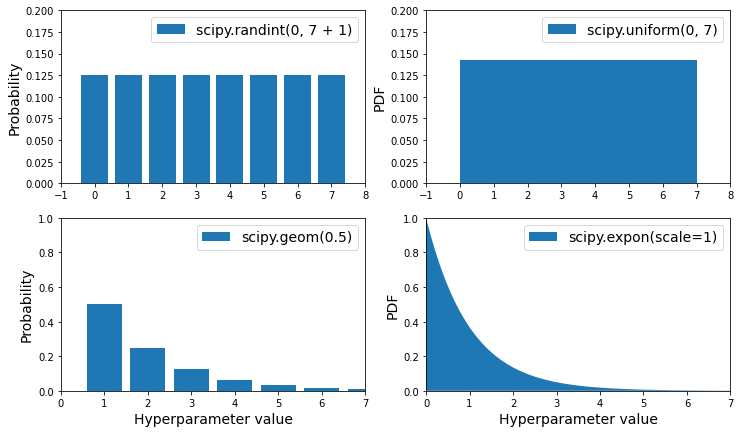

In [84]:
# let's plots a few distributions you can use in randomized search
xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

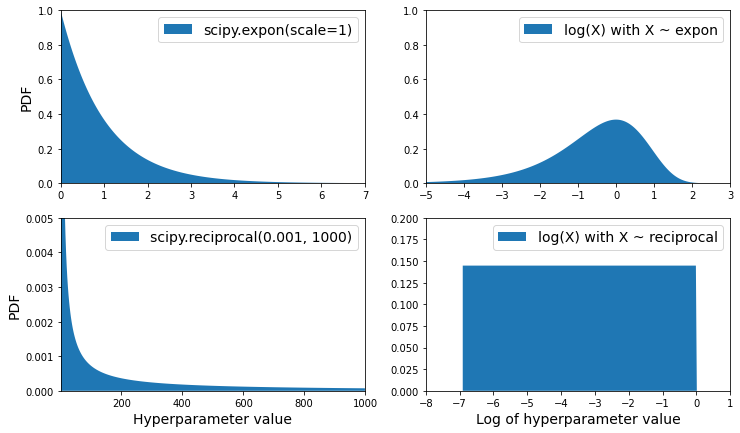

In [85]:
# let's shows the difference between expon and reciprocal
xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
reciprocal_distrib = reciprocal(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_reciprocal_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib, label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib, label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, reciprocal_distrib, label="scipy.reciprocal(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_reciprocal_distrib, label="log(X) with X ~ reciprocal")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

##Evaluate model

In [86]:
# Analyzing the Best Models and Their Errors
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.04, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.04,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.  , 0.01, 0.01, 0.  , 0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01,
       0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [87]:
# Let’s sort these importance scores
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.18658914478653787, 'log__median_income'),
 (0.08078603604072165, 'cat__ocean_proximity_INLAND'),
 (0.0736515117226182, 'bedrooms__ratio'),
 (0.051697179886742106, 'rooms_per_house__ratio'),
 (0.04467544232665202, 'people_per_house__ratio'),
 (0.040569125036286104, 'geo__Cluster 2 similarity'),
 (0.024707343640146137, 'geo__Cluster 12 similarity'),
 (0.02437900146527174, 'geo__Cluster 36 similarity'),
 (0.02259582389708218, 'geo__Cluster 41 similarity'),
 (0.020706363357609944, 'geo__Cluster 6 similarity'),
 (0.016288877164873577, 'geo__Cluster 7 similarity'),
 (0.015663527625441, 'geo__Cluster 29 similarity'),
 (0.015317959335675101, 'geo__Cluster 18 similarity'),
 (0.013821741771541378, 'geo__Cluster 1 similarity'),
 (0.013408962423244283, 'geo__Cluster 13 similarity'),
 (0.013202182869681492, 'geo__Cluster 40 similarity'),
 (0.012931545115635244, 'geo__Cluster 9 similarity'),
 (0.012320008527059882, 'geo__Cluster 0 similarity'),
 (0.012244832965442345, 'geo__Cluster 21 similarity

Now, we are ready to evaluate the final model on the test set.

In [ ]:
x_test stra